# ELEC-E8739 AI in Health Technologies: Medical Imaging Project

## Problem: Bone age prediction

### Completed by: Ekaterina Ustiukhina

# Prepare Dataset

## Mount Google Drive with the Bone Age dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Before you can proceed, you need to make sure that you have access to the data within your Google Drive space!

To get things right, create a shortcut to the folder you have been shared (folder named `ELEC-E8739_Final_Project_Ekaterina_Ustiukhina`). Find a link in the submitted `Readme` file.

This folder has been shared with Aalto organisation (viewer permissions).

## Alternative: Download the data

In order to run the following Notebook, make sure that training data is available within your Google Drive or locally (depends on how you run the notebook)!

Link to the dataset on Kagggle: https://www.kaggle.com/datasets/kmader/rsna-bone-age/data

Uncomment lines bellow to download the dataset from Kaggle.

Note: Dataset size is **~10Gb**

Note: **bonage-training-dataset/** (folder with training images) and **boneage-training-dataset.csv** are enough. Validation dataset from Kaggle is not used because it doesn't contain predictions.

In [ ]:
# !curl -L -o /content/drive/MyDrive/ELEC-E8739_Final_Project_Ekaterina_Ustiukhina/rsna-bone-age.zip \
#   https://www.kaggle.com/api/v1/datasets/download/kmader/rsna-bone-age
# !unzip /content/drive/MyDrive/ELEC-E8739_Final_Project_Ekaterina_Ustiukhina/rsna-bone-age.zip

Ensure you have the following content in the folder:

- bonage-training-dataset/

- boneage-training-dataset.csv

In [ ]:
!ls /content/drive/MyDrive/ELEC-E8739_Final_Project_Ekaterina_Ustiukhina

## Discoved bone images and build a Dataframe

Note: we take images from **training** subset only, because test and validation subsetf from Kaggle do not contain prediction values (bone age values).

In [2]:
import os
import pandas as pd

base_path = "/content/drive/MyDrive/ELEC-E8739_Final_Project_Ekaterina_Ustiukhina" # Set to folder where training data is located

df = pd.read_csv(os.path.join(base_path, "boneage-training-dataset.csv"))

base_folder = os.path.join(base_path, "boneage-training-dataset")

image_paths = []
for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(".png"):  # Adjust the extension if necessary
            image_paths.append(os.path.join(root, file))

# Function to find the image path for a given ID
def get_image_path(image_id):
    file_name = f"{image_id}.png"  # Adjust the extension if necessary
    for path in image_paths:
        if path.endswith(file_name):
            return path
    return None  # Handle missing images if any

# Add a new column to the DataFrame for image paths
df['image_path'] = df['id'].apply(get_image_path)

# Check for missing image paths
missing_images = df[df['image_path'].isnull()]
if not missing_images.empty:
    print("Missing images:", missing_images)
else:
    print("All images successfully mapped!")

# Display dataframe head
print(df.head())

All images successfully mapped!
     id  boneage   male                                         image_path
0  1377      180  False  /content/drive/MyDrive/Final_Project/boneage-t...
1  1378       12  False  /content/drive/MyDrive/Final_Project/boneage-t...
2  1379       94  False  /content/drive/MyDrive/Final_Project/boneage-t...
3  1380      120   True  /content/drive/MyDrive/Final_Project/boneage-t...
4  1381       82  False  /content/drive/MyDrive/Final_Project/boneage-t...


## Clean dataset

In [3]:
# Check for missing values in the dataset
print(df.isnull().sum())

# Drop rows with missing essential information
df = df.dropna(subset=['boneage', 'image_path'])

# Verify after cleaning
print(f"After null cleaning, dataset size: {len(df)}")

# Check for duplicate rows
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop duplicates
df = df.drop_duplicates()

# Verify after removing duplicates
print(f"After removing duplicates, dataset size: {len(df)}")

# Double Check for invalid image paths
valid_images = df['image_path'].apply(os.path.exists)
invalid_images = df[~valid_images]

# Drop rows with missing or invalid image paths
df = df[valid_images]

print(f"Number of invalid image paths removed: {len(invalid_images)}")

print(f"Final dataframe shape: {df.shape}")


id            0
boneage       0
male          0
image_path    0
dtype: int64
After null cleaning, dataset size: 12611
Number of duplicate rows: 0
After removing duplicates, dataset size: 12611
Number of invalid image paths removed: 0
Final dataframe shape: (12611, 4)


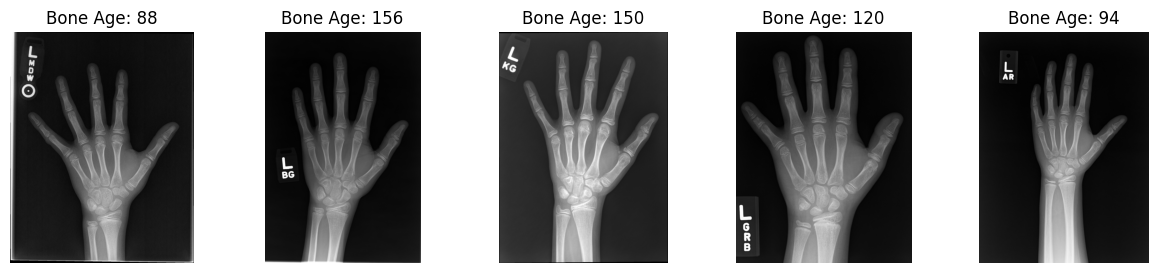

In [4]:
import matplotlib.pyplot as plt
import cv2

def show_sample_images(df, n=5):
    # Randomly sample n rows from the DataFrame
    sample_data = df.sample(n)

    # Create a plot with n subplots
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(sample_data.iterrows()):
        # Load the image
        image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
        # Display the image
        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap='gray')  # Assuming grayscale images
        plt.title(f"Bone Age: {row['boneage']}")
        plt.axis('off')
    plt.show()

# Visualize 5 sample images
show_sample_images(df)


## Pre-process (resize) images to speed-up the training

Original images have different height and width, so we resize them to 224x224 px.

We also store resized images to speed-up further training, otherwise image loading slows down the training significantly.

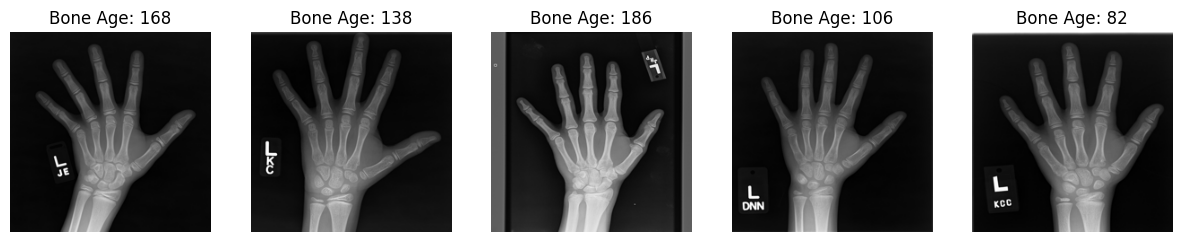

In [5]:
def resize_and_save_images(df, resized_output_folder):
    os.makedirs(resized_output_folder, exist_ok=True)  # Ensure the output folder exists

    build_resized_image_path = lambda x: os.path.join(resized_output_folder, f"{x}.png")

    for idx, row in df.iterrows():
        resized_image_path = build_resized_image_path(row['id'])  # Resized image path

        # Skip resizing if the file already exists
        if os.path.exists(resized_image_path):
            continue

        original_image_path = row['image_path']  # Original image path
        try:
            # Open, resize, and save the image
            with Image.open(original_image_path) as img:
                img_resized = img.resize((224, 224))  # Resize to 224x224
                img_resized.save(resized_image_path)
        except Exception as e:
            print(f"Error resizing image {original_image_path}: {e}")

    # Update the DataFrame to point to the resized image paths
    df['image_path'] = df['id'].apply(build_resized_image_path)


# Directories for resized images
train_resized_folder = os.path.join(base_path, "boneage-training-dataset-resized-224")

# Resize and update image paths for each split
resize_and_save_images(df, train_resized_folder)

# Visualize 5 resized images
show_sample_images(df, n=5)

## Split dataframe into train, validation and test subsets

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and temporary (20%)
train_set, temp_set = train_test_split(df, test_size=0.2, random_state=42)

# Split the temporary set into validation (10%) and test (10%)
val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# Display the sizes
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")


Training set size: 10088
Validation set size: 1261
Test set size: 1262


# Train Models

## Define dataset and model classes

Using pre-trained ResNet18 model for image recognition and replacing theclassification head with a regression head.

In [6]:
from torch.utils.data import Dataset
import torch.nn as nn
import timm
import cv2

class TimmResNetRegressor(nn.Module):
    def __init__(self):
        super(TimmResNetRegressor, self).__init__()
        self.model = timm.create_model('resnet18', pretrained=True) # Load pre-trained ResNet18 model from timm
        self.model.fc = nn.Linear(self.model.fc.in_features, 1) # Replace the classification head with a regression head

    def forward(self, x):
        return self.model(x)


class EnhancedResNetRegressor(nn.Module):
    def __init__(self):
        super(EnhancedResNetRegressor, self).__init__()
        self.model = timm.create_model('resnet18', pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3), # Add dropout for regularization
            nn.Linear(256, 1)  # Final regression layer
        )

    def forward(self, x):
        return self.model(x)


class BoneAgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
        boneage = row['boneage']
        if self.transform:
            image = self.transform({"image": image})["image"]

        return {'image': image, 'target': torch.tensor(boneage, dtype=torch.float32)}


## Define Config and Trainer classes

Trainer implementation was taken from Assignment 3.

In [7]:
!pip install solt

  Preparing metadata (setup.py) ... done
  Created wheel for solt: filename=solt-0.1.9-py3-none-any.whl size=26367 sha256=200cff9b89222887d78e376acd169aa961081d8cd00184db64b24cb0b1867026
  Stored in directory: /root/.cache/pip/wheels/1f/04/43/79bbcc6ff313329b07db7440e77e9a0bb0b61ccb5e4e840a42
Successfully built solt


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import gc
import sys
import solt as sl

class Config:
    def __init__(self, train_transform=None, val_transform=None, model_name="TimmResNetRegressor"):
        self.batch_size = 8
        self.lr = 0.001
        self.wd = 1e-4
        self.num_epochs = 30
        self.patience = 5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.loss = 'mse'
        self.lr_drop_milestones = [10, 15]  # Learning rate scheduler
        self.n_workers = 2

        self.train_transform = train_transform if train_transform != None else sl.Stream([])
        self.val_transform = val_transform if val_transform != None else sl.Stream([])

        self.model_name = model_name


class Trainer:
    def __init__(self, train_df, val_df, cfg):
        self.train_df = train_df
        self.val_df = val_df

        self.train_loader = None
        self.val_loader = None
        self.loss_fn = None
        self.optimizer = None
        self.model = None
        self.cfg = cfg

    def init_model(self):
        # Clear previous model and cache
        if hasattr(self, "model"):
            del self.model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        # Initialize model
        if self.cfg.model_name == "EnhancedResNetRegressor":
          self.model = EnhancedResNetRegressor().to(self.cfg.device)
        else:
          self.model = TimmResNetRegressor().to(self.cfg.device)

    def init_run(self):
        # Clear loaders and optimizer
        del self.train_loader
        del self.val_loader
        del self.optimizer

        gc.collect()
        torch.cuda.empty_cache()

        self.init_model()

        # Initialize data loaders
        train_ds = BoneAgeDataset(self.train_df, transform=self.cfg.train_transform)
        val_ds = BoneAgeDataset(self.val_df, transform=self.cfg.val_transform)

        self.train_loader = DataLoader(train_ds,
                                       batch_size=self.cfg.batch_size,
                                       shuffle=True,
                                       num_workers=self.cfg.n_workers)

        self.val_loader = DataLoader(val_ds,
                                     batch_size=self.cfg.batch_size,
                                     shuffle=False,
                                     num_workers=self.cfg.n_workers)

        # Initialize optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=self.cfg.lr,
                                          weight_decay=self.cfg.wd)

        # Initialize loss function
        if self.cfg.loss == 'mse':
            self.loss_fn = torch.nn.MSELoss()
        elif self.cfg.loss == 'mae':
            self.loss_fn = torch.nn.L1Loss()
        else:
            raise NotImplementedError(f"Loss function {self.cfg.loss} is not implemented")

    def pass_batch(self, batch):
        images = batch['image'].to(self.cfg.device)
        targets = batch['target'].to(self.cfg.device)

        # Forward pass
        outputs = self.model(images).squeeze(1)  # Squeeze to match regression output
        loss = self.loss_fn(outputs, targets)

        return loss, outputs

    def train_epoch(self):
        self.model.train()
        pbar = tqdm(total=len(self.train_loader), position=0, leave=True)

        running_loss = 0

        # Adjust learning rate if needed
        if self.epoch in self.cfg.lr_drop_milestones:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= 0.1

        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            loss, _ = self.pass_batch(batch)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            cur_loss = running_loss / (i + 1)

            desc = f'[{self.epoch}] Train {loss.item():.4f} / {cur_loss:.4f}'
            pbar.set_description(desc)
            pbar.update()

        pbar.close()
        running_loss /= len(self.train_loader)
        return running_loss

    def val_epoch(self):
        self.model.eval()
        preds = []
        gt = []
        running_loss = 0

        pbar = tqdm(total=len(self.val_loader), desc=f"[{self.epoch}] Validation....", position=0, leave=True)
        with torch.no_grad():
            for i, batch in enumerate(self.val_loader):
                loss, outputs = self.pass_batch(batch)
                running_loss += loss.item()

                preds.append(outputs.cpu())
                gt.append(batch['target'].cpu())
                pbar.update()

        preds = torch.cat(preds).numpy()
        gt = torch.cat(gt).numpy()

        mae = mean_absolute_error(gt, preds)
        mse = mean_squared_error(gt, preds)
        running_loss /= len(self.val_loader)

        pbar.close()
        return running_loss, mae, mse, preds, gt

    def run(self, n_epochs=None):
      self.init_run()
      if n_epochs is None:
          n_epochs = self.cfg.num_epochs

      # Early stopping variables
      patience = self.cfg.patience  # Add patience to Config class, e.g., self.patience = 5
      best_loss = float('inf')  # Initialize best validation loss as infinity
      epochs_without_improvement = 0

      train_losses = []
      val_losses = []

      for self.epoch in range(n_epochs):
          # Training phase
          train_loss = self.train_epoch()
          train_losses.append(train_loss)

          # Validation phase
          val_loss, val_mae, val_mse, _, _ = self.val_epoch()
          val_losses.append(val_loss)

          # Check for improvement in validation loss
          if val_loss < best_loss:
              best_loss = val_loss  # Update the best validation loss
              epochs_without_improvement = 0  # Reset counter
          else:
              epochs_without_improvement += 1  # Increment counter

          # Print metrics
          sys.stderr.flush()
          print("=" * 50)
          print(f"[{self.epoch}] --> Train Loss : {train_loss:.4f}")
          print(f"[{self.epoch}] --> Val Loss   : {val_loss:.4f}")
          print(f"[{self.epoch}] --> Val MAE    : {val_mae:.4f}")
          print(f"[{self.epoch}] --> Val MSE    : {val_mse:.4f}")
          print("=" * 50)

          # Comment this sections to show overfitting on Baseline model
          # Check for early stopping
          # if epochs_without_improvement >= patience:
          #     print(f"Early stopping at epoch {self.epoch} due to no improvement in validation loss.")
          #     break

      return train_losses, val_losses


## Train Baseline model

In [ ]:
# Initialize Config
baseline_cfg = Config()

# Initialize Trainer
baseline_trainer = Trainer(train_df=train_set, val_df=val_set, cfg=baseline_cfg)

# Train the model
baseline_train_losses, baseline_val_losses = baseline_trainer.run(n_epochs=baseline_cfg.num_epochs)

# Store the model and train/val losses
torch.save(baseline_trainer.model.state_dict(), os.path.join(base_path,"baseline_model.pth"))
torch.save(baseline_train_losses, os.path.join(base_path, f"baseline_train_losses.pt"))
torch.save(baseline_val_losses, os.path.join(base_path, f"baseline_val_losses.pt"))

[0] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 123.32it/s]


[0] --> Train Loss : 2013.5560
[0] --> Val Loss   : 1193.7161
[0] --> Val MAE    : 26.6937
[0] --> Val MSE    : 1193.4282


[1] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.71it/s]


[1] --> Train Loss : 863.8247
[1] --> Val Loss   : 1057.7558
[1] --> Val MAE    : 21.5363
[1] --> Val MSE    : 1059.0289


[2] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.74it/s]


[2] --> Train Loss : 821.0101
[2] --> Val Loss   : 871.7318
[2] --> Val MAE    : 21.6428
[2] --> Val MSE    : 872.5654


[3] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.29it/s]


[3] --> Train Loss : 767.2991
[3] --> Val Loss   : 912.9542
[3] --> Val MAE    : 22.7207
[3] --> Val MSE    : 913.3953


[4] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.91it/s]


[4] --> Train Loss : 738.1427
[4] --> Val Loss   : 1167.7971
[4] --> Val MAE    : 25.2121
[4] --> Val MSE    : 1168.9102


[5] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.57it/s]


[5] --> Train Loss : 711.3265
[5] --> Val Loss   : 863.3421
[5] --> Val MAE    : 19.8329
[5] --> Val MSE    : 864.4817


[6] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.38it/s]


[6] --> Train Loss : 681.5128
[6] --> Val Loss   : 912.2324
[6] --> Val MAE    : 21.5023
[6] --> Val MSE    : 913.3046


[7] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.67it/s]


[7] --> Train Loss : 657.5333
[7] --> Val Loss   : 888.8783
[7] --> Val MAE    : 20.5067
[7] --> Val MSE    : 889.8277


[8] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.86it/s]


[8] --> Train Loss : 620.5435
[8] --> Val Loss   : 952.2265
[8] --> Val MAE    : 20.8703
[8] --> Val MSE    : 953.4047


[9] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.63it/s]


[9] --> Train Loss : 590.9294
[9] --> Val Loss   : 916.9948
[9] --> Val MAE    : 20.4330
[9] --> Val MSE    : 917.9445


[10] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.56it/s]


[10] --> Train Loss : 464.2700
[10] --> Val Loss   : 996.9043
[10] --> Val MAE    : 21.0778
[10] --> Val MSE    : 997.6207


[11] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.44it/s]


[11] --> Train Loss : 431.5818
[11] --> Val Loss   : 1007.3949
[11] --> Val MAE    : 21.0391
[11] --> Val MSE    : 1007.7583


[12] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 124.18it/s]


[12] --> Train Loss : 411.8806
[12] --> Val Loss   : 1078.3431
[12] --> Val MAE    : 21.9621
[12] --> Val MSE    : 1078.1384


[13] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 125.88it/s]


[13] --> Train Loss : 400.2255
[13] --> Val Loss   : 1059.4773
[13] --> Val MAE    : 21.6744
[13] --> Val MSE    : 1059.3167


[14] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.06it/s]


[14] --> Train Loss : 389.4275
[14] --> Val Loss   : 1092.6918
[14] --> Val MAE    : 21.9459
[14] --> Val MSE    : 1092.4586


[15] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.93it/s]


[15] --> Train Loss : 362.4989
[15] --> Val Loss   : 1107.1673
[15] --> Val MAE    : 22.1886
[15] --> Val MSE    : 1106.7413


[16] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.22it/s]


[16] --> Train Loss : 359.4586
[16] --> Val Loss   : 1115.2397
[16] --> Val MAE    : 22.1694
[16] --> Val MSE    : 1114.7234


[17] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.29it/s]


[17] --> Train Loss : 361.1615
[17] --> Val Loss   : 1115.1949
[17] --> Val MAE    : 22.2607
[17] --> Val MSE    : 1114.6062


[18] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.36it/s]


[18] --> Train Loss : 358.3888
[18] --> Val Loss   : 1117.9864
[18] --> Val MAE    : 22.2697
[18] --> Val MSE    : 1117.3252


[19] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.58it/s]


[19] --> Train Loss : 353.9979
[19] --> Val Loss   : 1113.4732
[19] --> Val MAE    : 22.3043
[19] --> Val MSE    : 1112.7188


[20] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.16it/s]


[20] --> Train Loss : 355.6289
[20] --> Val Loss   : 1120.1626
[20] --> Val MAE    : 22.2312
[20] --> Val MSE    : 1119.4929


[21] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.95it/s]


[21] --> Train Loss : 353.4063
[21] --> Val Loss   : 1127.7615
[21] --> Val MAE    : 22.3988
[21] --> Val MSE    : 1127.0386


[22] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.93it/s]


[22] --> Train Loss : 353.5867
[22] --> Val Loss   : 1128.1852
[22] --> Val MAE    : 22.3495
[22] --> Val MSE    : 1127.3926


[23] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.11it/s]


[23] --> Train Loss : 351.1240
[23] --> Val Loss   : 1134.1298
[23] --> Val MAE    : 22.4243
[23] --> Val MSE    : 1133.2928


[24] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 125.82it/s]


[24] --> Train Loss : 351.0140
[24] --> Val Loss   : 1127.2194
[24] --> Val MAE    : 22.3829
[24] --> Val MSE    : 1126.3448


[25] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.85it/s]


[25] --> Train Loss : 348.4657
[25] --> Val Loss   : 1133.8777
[25] --> Val MAE    : 22.4257
[25] --> Val MSE    : 1132.9713


[26] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.16it/s]


[26] --> Train Loss : 346.6583
[26] --> Val Loss   : 1144.1130
[26] --> Val MAE    : 22.5620
[26] --> Val MSE    : 1143.1423


[27] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.93it/s]


[27] --> Train Loss : 348.2535
[27] --> Val Loss   : 1148.8150
[27] --> Val MAE    : 22.6100
[27] --> Val MSE    : 1147.8021


[28] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.29it/s]


[28] --> Train Loss : 346.3769
[28] --> Val Loss   : 1148.2220
[28] --> Val MAE    : 22.5059
[28] --> Val MSE    : 1147.2831


[29] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 125.71it/s]


[29] --> Train Loss : 347.1589
[29] --> Val Loss   : 1155.5420
[29] --> Val MAE    : 22.5472
[29] --> Val MSE    : 1154.5807


## Train Improved model

Apply image augmantation for training dataset

In [8]:
import solt as sl
import solt.transforms as slt

train_transforms = sl.Stream([
    slt.Rotate((-15, 15), padding='r'),
    slt.Shear(range_x=(-0.2, 0.2), range_y=(-0.2, 0.2), padding='r'),
    slt.Scale(range_x=(0.9, 1.2), range_y=(0.9, 1.2), same=False, padding='r'),
    slt.Contrast(contrast_range=(0.7, 1.5)),
    slt.Brightness(brightness_range=(0.7, 1.3)),
    slt.Blur(p=0.2, blur_type='m', k_size=(5,)),
    slt.SaltAndPepper(p=0.15, gain_range=(0.03, 0.08)),
    slt.HSV(h_range=(-5, 5), s_range=(-5, 5)),
    slt.Crop(224, crop_mode='r'),
])

val_transforms = sl.Stream([])

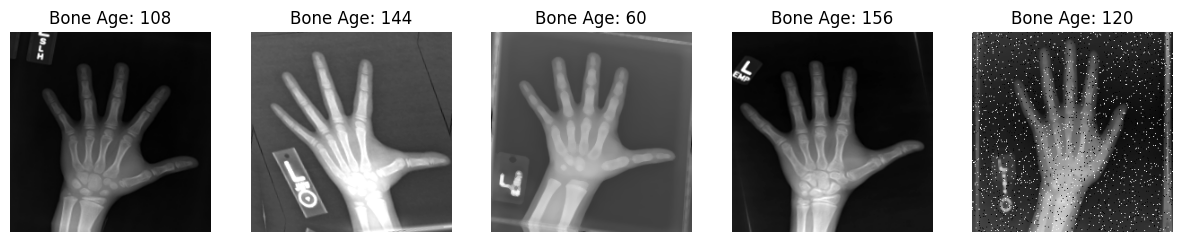

In [14]:
import matplotlib.pyplot as plt
import cv2

def show_sample_images_aug(df, n=5):
    # Randomly sample n rows from the DataFrame
    sample_data = df.sample(n)

    # Create a plot with n subplots
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(sample_data.iterrows()):
        # Load the image
        image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
        image = train_transforms(image, return_torch=False, normalize=False).data[0]
        # Display the image
        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap='gray')  # Assuming grayscale images
        plt.title(f"Bone Age: {row['boneage']}")
        plt.axis('off')
    plt.show()

# Visualize 5 sample images
show_sample_images_aug(df)

In [ ]:
# Initialize trainer
improved_cfg = Config(train_transforms, val_transforms, model_name="EnhancedResNetRegressor")
improved_trainer = Trainer(train_df=train_set, val_df=val_set, cfg=improved_cfg)

# Train the model
improved_train_losses, improved_val_losses = improved_trainer.run(n_epochs=improved_cfg.num_epochs)

# Store losses
torch.save(improved_trainer.model.state_dict(), os.path.join(base_path,"improved_model.pth"))
torch.save(improved_train_losses, os.path.join(base_path, f"improved_train_losses.pt"))
torch.save(improved_val_losses, os.path.join(base_path, f"improved_val_losses.pt"))

[0] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 125.75it/s]


[0] --> Train Loss : 1762.8898
[0] --> Val Loss   : 1182.7962
[0] --> Val MAE    : 26.8564
[0] --> Val MSE    : 1183.1122


[1] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.13it/s]


[1] --> Train Loss : 1133.6522
[1] --> Val Loss   : 1193.5243
[1] --> Val MAE    : 27.2955
[1] --> Val MSE    : 1194.4650


[2] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.57it/s]


[2] --> Train Loss : 1085.2676
[2] --> Val Loss   : 885.8952
[2] --> Val MAE    : 21.3398
[2] --> Val MSE    : 886.7468


[3] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.20it/s]


[3] --> Train Loss : 1036.1719
[3] --> Val Loss   : 894.3045
[3] --> Val MAE    : 20.6826
[3] --> Val MSE    : 895.5129


[4] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.08it/s]


[4] --> Train Loss : 1006.7666
[4] --> Val Loss   : 859.1295
[4] --> Val MAE    : 20.6357
[4] --> Val MSE    : 859.5488


[5] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.96it/s]


[5] --> Train Loss : 985.9026
[5] --> Val Loss   : 863.7603
[5] --> Val MAE    : 21.3561
[5] --> Val MSE    : 864.1443


[6] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.59it/s]


[6] --> Train Loss : 979.1020
[6] --> Val Loss   : 844.9643
[6] --> Val MAE    : 19.8192
[6] --> Val MSE    : 845.3124


[7] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.75it/s]


[7] --> Train Loss : 959.8507
[7] --> Val Loss   : 861.0304
[7] --> Val MAE    : 19.9832
[7] --> Val MSE    : 861.1916


[8] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 129.54it/s]


[8] --> Train Loss : 954.7441
[8] --> Val Loss   : 846.6733
[8] --> Val MAE    : 20.4005
[8] --> Val MSE    : 847.3077


[9] Validation....: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 124.34it/s]


[9] --> Train Loss : 937.9807
[9] --> Val Loss   : 838.2752
[9] --> Val MAE    : 19.1237
[9] --> Val MSE    : 838.7914


[10] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.54it/s]


[10] --> Train Loss : 869.5618
[10] --> Val Loss   : 802.7855
[10] --> Val MAE    : 18.9014
[10] --> Val MSE    : 803.4113


[11] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.12it/s]


[11] --> Train Loss : 843.7881
[11] --> Val Loss   : 796.1650
[11] --> Val MAE    : 19.0634
[11] --> Val MSE    : 796.8145


[12] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.83it/s]


[12] --> Train Loss : 839.4642
[12] --> Val Loss   : 798.0051
[12] --> Val MAE    : 19.3727
[12] --> Val MSE    : 798.6009


[13] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.91it/s]


[13] --> Train Loss : 829.4853
[13] --> Val Loss   : 791.8287
[13] --> Val MAE    : 18.9823
[13] --> Val MSE    : 792.5343


[14] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 126.38it/s]


[14] --> Train Loss : 832.7229
[14] --> Val Loss   : 788.0321
[14] --> Val MAE    : 19.0706
[14] --> Val MSE    : 788.6965


[15] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.89it/s]


[15] --> Train Loss : 831.6826
[15] --> Val Loss   : 787.5835
[15] --> Val MAE    : 19.0765
[15] --> Val MSE    : 788.2745


[16] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 129.18it/s]


[16] --> Train Loss : 815.8117
[16] --> Val Loss   : 785.9442
[16] --> Val MAE    : 18.7790
[16] --> Val MSE    : 786.6841


[17] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.59it/s]


[17] --> Train Loss : 817.8791
[17] --> Val Loss   : 788.4670
[17] --> Val MAE    : 18.7740
[17] --> Val MSE    : 789.2692


[18] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.56it/s]


[18] --> Train Loss : 810.4467
[18] --> Val Loss   : 784.8557
[18] --> Val MAE    : 18.5889
[18] --> Val MSE    : 785.7118


[19] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.53it/s]


[19] --> Train Loss : 820.6764
[19] --> Val Loss   : 784.3741
[19] --> Val MAE    : 18.8083
[19] --> Val MSE    : 785.1627


[20] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.11it/s]


[20] --> Train Loss : 815.8739
[20] --> Val Loss   : 785.3854
[20] --> Val MAE    : 18.7801
[20] --> Val MSE    : 786.2035


[21] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.28it/s]


[21] --> Train Loss : 811.6266
[21] --> Val Loss   : 783.3775
[21] --> Val MAE    : 18.7583
[21] --> Val MSE    : 784.2146


[22] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.10it/s]


[22] --> Train Loss : 815.5619
[22] --> Val Loss   : 784.0654
[22] --> Val MAE    : 18.5752
[22] --> Val MSE    : 784.9574


[23] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.57it/s]


[23] --> Train Loss : 811.6967
[23] --> Val Loss   : 787.4870
[23] --> Val MAE    : 18.8385
[23] --> Val MSE    : 788.3307


[24] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.13it/s]


[24] --> Train Loss : 801.3284
[24] --> Val Loss   : 784.0865
[24] --> Val MAE    : 18.8504
[24] --> Val MSE    : 784.9255


[25] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.64it/s]


[25] --> Train Loss : 808.6422
[25] --> Val Loss   : 784.4461
[25] --> Val MAE    : 18.6908
[25] --> Val MSE    : 785.3528


[26] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.56it/s]


[26] --> Train Loss : 816.9307
[26] --> Val Loss   : 783.5231
[26] --> Val MAE    : 18.5838
[26] --> Val MSE    : 784.4101


[27] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 125.71it/s]


[27] --> Train Loss : 809.2058
[27] --> Val Loss   : 782.9426
[27] --> Val MAE    : 18.6404
[27] --> Val MSE    : 783.8472


[28] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 127.09it/s]


[28] --> Train Loss : 809.3780
[28] --> Val Loss   : 785.2267
[28] --> Val MAE    : 18.7485
[28] --> Val MSE    : 786.1605


[29] Validation....: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:01<00:00, 128.97it/s]


[29] --> Train Loss : 816.5467
[29] --> Val Loss   : 786.2048
[29] --> Val MAE    : 18.8507
[29] --> Val MSE    : 787.0834


# Compare Models

## Bootstrap comparison

In [ ]:
import torch
from sklearn.metrics import mean_absolute_error
from PIL import Image
from torchvision.transforms import ToTensor
import numpy as np

cfg = Config()

# Move models to the appropriate device
baseline_model = baseline_trainer.model.to(cfg.device)
improved_model = improved_trainer.model.to(cfg.device)

# Set models to evaluation mode
baseline_model.eval()
improved_model.eval()

def bootstrap_comparison(model1, model2, dataset, metric_fn, n_bootstrap=100):
    diff_distribution = []

    for _ in range(n_bootstrap):
        # Resample the dataset with replacement
        indices = np.random.choice(len(dataset), len(dataset), replace=True)
        resampled_data = dataset.iloc[indices]  # Use .iloc for DataFrame

        # Extract predictions and ground truths for both models
        gt = []
        preds_model1 = []
        preds_model2 = []

        for _, row in resampled_data.iterrows():
            image_path = row['image_path']
            boneage = row['boneage']

            # Prepare image
            image = Image.open(image_path).convert("RGB")
            input_image = ToTensor()(image).unsqueeze(0).to(cfg.device)
            gt.append(boneage)

            with torch.no_grad():
                preds_model1.append(model1(input_image).item())
                preds_model2.append(model2(input_image).item())

        # Calculate metric difference
        metric1 = metric_fn(gt, preds_model1)
        metric2 = metric_fn(gt, preds_model2)
        diff_distribution.append(metric2 - metric1)  # Improved - Baseline

    return np.array(diff_distribution)


# Compare baseline_model and improved_model
diff_distribution = bootstrap_comparison(
    baseline_model, improved_model, val_set, mean_absolute_error, n_bootstrap=10
)

# Summarize results
mean_diff = np.mean(diff_distribution)
ci_lower, ci_upper = np.percentile(diff_distribution, [2.5, 97.5])

print(f"Mean MAE Difference (Improved - Baseline): {mean_diff:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

Mean MAE Difference (Improved - Baseline): -3.243
95% CI: [-3.857, -2.386]


## Compare losses



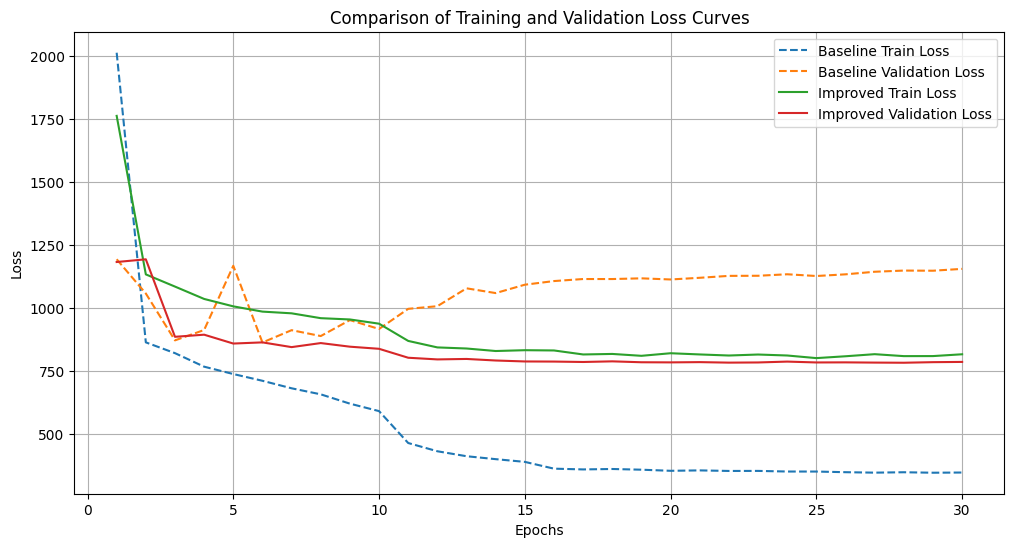

In [ ]:
# Reload losses
# baseline_train_losses = torch.load(os.path.join(base_path, "baseline_train_losses.pt"))
# baseline_val_losses = torch.load(os.path.join(base_path, "baseline_val_losses.pt"))

# improved_train_losses = torch.load(os.path.join(base_path, "improved_train_losses.pt"))
# improved_val_losses = torch.load(os.path.join(base_path, "improved_val_losses.pt"))

epochs = range(1, len(baseline_train_losses) + 1)

plt.figure(figsize=(12, 6))

# Baseline model
plt.plot(epochs, baseline_train_losses, label="Baseline Train Loss", linestyle='--')
plt.plot(epochs, baseline_val_losses, label="Baseline Validation Loss", linestyle='--')

# Improved model
plt.plot(epochs, improved_train_losses, label="Improved Train Loss")
plt.plot(epochs, improved_val_losses, label="Improved Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Training and Validation Loss Curves")
plt.legend()
plt.grid()
plt.show()

## Compare predictions

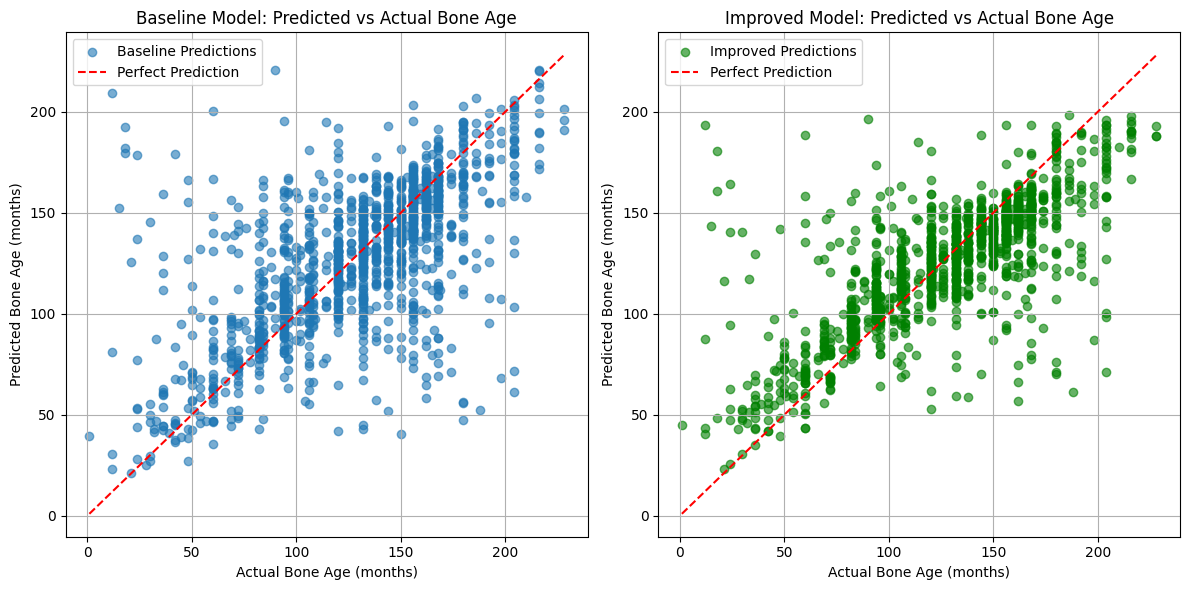

In [ ]:
from torch.utils.data import DataLoader
# Collect predictions and actual values
def collect_predictions(model, data_loader, device='cpu'):

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            targets = batch['target'].to(device)

            # Model predictions
            preds = model(images).squeeze(1).cpu().numpy()  # Convert to numpy
            targets = targets.cpu().numpy()

            predictions.extend(preds)
            actuals.extend(targets)

    return predictions, actuals

cfg = Config()

# Move models to the appropriate device
baseline_model = baseline_trainer.model.to(cfg.device)
improved_model = improved_trainer.model.to(cfg.device)

# Set models to evaluation mode
baseline_model.eval()
improved_model.eval()

val_dataset = BoneAgeDataset(val_set, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Predictions for baseline model
baseline_preds, actuals = collect_predictions(baseline_model, val_loader, device=cfg.device)

# Predictions for improved model
improved_preds, _ = collect_predictions(improved_model, val_loader, device=cfg.device)

# Scatter plot for baseline model
plt.figure(figsize=(12, 6))

# Baseline model predictions
plt.subplot(1, 2, 1)
plt.scatter(actuals, baseline_preds, alpha=0.6, label="Baseline Predictions")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Bone Age (months)")
plt.ylabel("Predicted Bone Age (months)")
plt.title("Baseline Model: Predicted vs Actual Bone Age")
plt.legend()
plt.grid()

# Improved model predictions
plt.subplot(1, 2, 2)
plt.scatter(actuals, improved_preds, alpha=0.6, color="green", label="Improved Predictions")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Bone Age (months)")
plt.ylabel("Predicted Bone Age (months)")
plt.title("Improved Model: Predicted vs Actual Bone Age")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()